Declararea librariilor necesare

In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import re
import string
import spacy
from spacy.lang.ro.stop_words import STOP_WORDS as stopwords_ro
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

Incarc modelul pentru limba romana din spaCy

In [88]:
nlp_ro = spacy.load("ro_core_news_sm")

Preiau setul de date

In [89]:
news_data = pd.read_excel('C:/Users/darius/OneDrive/Desktop/University/Licenta/Cod sursa/SetDateStiri.xlsx')

Verific daca s-au incarcat corect datele

In [90]:
news_data.head()

,URL,Titlu,Text,Publicatie,Subiect,Credibilate
0,https://cuvantulnatiunii.ro/2023/08/01/claudia...,"CLAUDIA MARCU – Încălzirea globală, o manipula...",Încălzirea globală este doar o agendă politică...,cuvantulnatiunii,incalzire globala,0
1,https://www.stiintaonline.ro/de-ce-incalzirea-...,De ce încălzirea globală nu poate fi atribuită...,Ultimul deceniu (2010-2019) a fost cel mai cal...,stiintaonline,incalzire globala,1
2,https://www.dcnews.ro/si-inainte-erau-veri-de-...,Şi înainte erau veri de foc şi n-a mai murit n...,Am trăit verile dinainte de '90. Erau la fel d...,dcnews,incalzire globala,0
3,https://www.zf.ro/business-international/incal...,Încălzirea globală – un mit? Hackerii au desco...,Business Internaţional\n\nÎncălzirea globală ş...,zf,incalzire globala,0
4,https://www.hotnews.ro/stiri-mediu-26673559-ca...,"Câteva mituri despre încălzirea globală, expli...","MEDIU Vineri, 10 Noiembrie 2023, 11:51\n\n46\n...",hotnews,incalzire globala,1


Renunt la coloana 'URL' a setului de date, deoarece nu este necesara modelului

In [91]:
data = news_data.drop(['URL'], axis = 1)

Verific daca am valori nule in coloane

In [92]:
data.isnull().sum()

Titlu          0
Text           0
Publicatie     0
Subiect        0
Credibilate    0
dtype: int64

Amestec setul de date si resetez indexul

In [93]:
data = data.sample(frac=1).reset_index(drop=True)

Verific daca s-a produs amestecarea

In [94]:
data.head()

,Titlu,Text,Publicatie,Subiect,Credibilate
0,Documentar VIDEO NANOCAPSULE IN VACCINURILE CO...,Traducătorul Ionel Trandafir ne prezintă: „NAN...,Active News,covid-19,0
1,De ce are Piedone un sprijin atât de mare în r...,"POLITIC\nSâmbătă, 04 Mai 2024, 13:14\nDe ce ar...",HotNews,politica,1
2,PNL şi PSD cer convocarea unei şedinţe de CGMB...,PNL şi PSD cer convocarea unei şedinţe de CGMB...,Observator,politica,1
3,Premieră în guvernarea PSD: suma-record invest...,Iar acest lucru se simte și în faptul că român...,Romania TV,politica,1
4,"Klaus Iohannis, discurs de Ziua Independenței ...","Kaus Iohannis a scos în evidență faptul că, de...",Romania TV,politica,1


Functie pentru extragerea numelor mentionate

In [95]:
def extract_names(text):
    doc = nlp_ro(text)
    names = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    return " ".join(names)

data['Names_Text'] = data['Text'].apply(lambda x: extract_names(x) if x else 'no_name')
data['Names_Titlu'] = data['Titlu'].apply(lambda x: extract_names(x) if x else 'no_name')

Definirea unei functii pentru preprocesarea (curatarea) textului

In [96]:
def wordopt(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub('\\[.*?\\]', '', text)
        text = re.sub("\\W", " ", text)
        text = re.sub('https?://\\S+|www\\.\\S+', '', text)
        text = re.sub('<.*?>+', '', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\n', '', text)
        text = re.sub('\\w*\\d\\w*', '', text)
        text = ' '.join([word for word in text.split() if word not in stopwords_ro])
        text = ' '.join([token.lemma_ for token in nlp_ro(text)])
    return text

from spacy.lang.ro.stop_words import STOP_WORDS as stopwords_ro


Functie pentru preprocesarea publicatiei

In [97]:
def preprocess_publicatie(text):
    if isinstance(text, str):
        text = text.lower()
        text = text.replace(' ', '')
    return text

Aplic preprocesarea pentru fiecare coloana

In [98]:
# data['Text'] = data['Text'].apply(wordopt)
# data['Titlu'] = data['Titlu'].apply(wordopt)
# data['Publicatie'] = data['Publicatie'].apply(preprocess_publicatie)

Functie pentru cautarea prezentei cuvintelor prezente de obicei in conspiratii

In [99]:
keywords = [
    "Noua Ordine Mondială", "Marea Resetare", "plandemie", "microcipare", "Big Pharma", "5G", "QAnon", "chemtrails", "shedding", "Statul paralel"
]

In [100]:
def contains_keywords(text, keywords):
    text = text.lower()
    return any(keyword.lower() in text for keyword in keywords)

In [101]:
data['Cuvinte_Cheie_Titlu'] = data['Titlu'].apply(lambda x: contains_keywords(x, keywords))
data['Cuvinte_Cheie_Text'] = data['Text'].apply(lambda x: contains_keywords(x, keywords))

data['Cuvinte_Cheie'] = data['Cuvinte_Cheie_Titlu'] | data['Cuvinte_Cheie_Text']

In [102]:
data['Text'] = data['Text'].apply(wordopt)
data['Titlu'] = data['Titlu'].apply(wordopt)
data['Publicatie'] = data['Publicatie'].apply(preprocess_publicatie)

Functie care influenteaza decizia algoritmilor dupa identificarea cuvintelor

In [103]:
# def adjust_predictions(predictions, keyword_feature):
#     adjusted_predictions = []
#     for pred, keyword in zip(predictions, keyword_feature):
#         if keyword:
#             adjusted_predictions.append(0) 
#         else:
#             adjusted_predictions.append(pred)
#     return adjusted_predictions

Impart setul de date in 70% antrenare si 30% testare

In [104]:
x_train, x_test, y_train, y_test = train_test_split(
    data[['Text', 'Publicatie', 'Titlu', 'Subiect', 'Names_Text', 'Names_Titlu', 'Cuvinte_Cheie']], 
    data['Credibilate'], 
    test_size=0.30, 
    stratify=data['Credibilate']
)

Vectorizarea separata a coloanelor 

In [105]:
vectorizer_text = TfidfVectorizer()
vectorizer_publicatie = TfidfVectorizer()
vectorizer_titlu = TfidfVectorizer()
vectorizer_subiect = TfidfVectorizer()

vectorizer_names_text = TfidfVectorizer()
vectorizer_names_titlu = TfidfVectorizer()

In [106]:
xv_train_text = vectorizer_text.fit_transform(x_train['Text'].fillna(''))
xv_train_publicatie = vectorizer_publicatie.fit_transform(x_train['Publicatie'].fillna(''))
xv_train_titlu = vectorizer_titlu.fit_transform(x_train['Titlu'].fillna(''))
xv_train_subiect = vectorizer_subiect.fit_transform(x_train['Subiect'].fillna(''))

xv_train_names_text = vectorizer_names_text.fit_transform(x_train['Names_Text'].fillna(''))
xv_train_names_titlu = vectorizer_names_titlu.fit_transform(x_train['Names_Titlu'].fillna(''))
xv_train_keywords = csr_matrix(x_train['Cuvinte_Cheie']).transpose()

xv_test_text = vectorizer_text.transform(x_test['Text'].fillna(''))
xv_test_publicatie = vectorizer_publicatie.transform(x_test['Publicatie'].fillna(''))
xv_test_titlu = vectorizer_titlu.transform(x_test['Titlu'].fillna(''))
xv_test_subiect = vectorizer_subiect.transform(x_test['Subiect'].fillna(''))

xv_test_names_text = vectorizer_names_text.transform(x_test['Names_Text'].fillna(''))
xv_test_names_titlu = vectorizer_names_titlu.transform(x_test['Names_Titlu'].fillna(''))
xv_test_keywords = csr_matrix(x_test['Cuvinte_Cheie']).transpose()

Combin vectorii intr-o singura matrice pentru features

In [107]:
xv_train = hstack([xv_train_text, xv_train_publicatie, xv_train_titlu, xv_train_subiect, xv_train_names_text, xv_train_names_titlu, xv_train_keywords])

xv_test = hstack([xv_test_text, xv_test_publicatie, xv_test_titlu, xv_test_subiect, xv_test_names_text, xv_test_names_titlu, xv_test_keywords])

# Improvements TO-DO:

- Feature creat din cuvinte cheie care sa influenteze decizia algoritmilor (ex: Stirile conspirationiste, evident false, contin termeni precum "Noua Ordine Mondiala", "Marea Resetare" etc.)
- Sa se poata tine evidenta de cate cuvinte sunt scrise cu caps-lock in articole (site-urile conspirationiste tind sa scrie lucrurile alarmante folosind caps-lock)

Primul algoritm: Logistic Regression cu hyperparameter tuning folosind GridSearchCV

In [108]:
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag'],
    'max_iter': [300, 500, 1000]
}

In [109]:
grid = GridSearchCV(LogisticRegression(), param_grid, refit=True, verbose=0, cv=5)
grid.fit(xv_train, y_train)

c:\Users\darius\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\darius\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\darius\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\darius\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\darius\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100], 'max_iter': [300, 500, 1000],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag']})

In [110]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 1, 'max_iter': 300, 'solver': 'liblinear'}
LogisticRegression(C=1, max_iter=300, solver='liblinear')


In [111]:
pred_lr = grid.predict(xv_test)
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.72      0.37      0.49        57
           1       0.76      0.93      0.84       120

    accuracy                           0.75       177
   macro avg       0.74      0.65      0.66       177
weighted avg       0.75      0.75      0.72       177



In [112]:
# adjusted_pred_lr = adjust_predictions(pred_lr, x_test['Cuvinte_Cheie'])
# print(classification_report(y_test, adjusted_pred_lr))

Al doilea algoritm: Decision Tree Classifier

In [113]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(xv_train, y_train)

DecisionTreeClassifier()

In [114]:
pred_dt = DT.predict(xv_test)

In [115]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

           0       0.56      0.53      0.54        57
           1       0.78      0.80      0.79       120

    accuracy                           0.71       177
   macro avg       0.67      0.66      0.67       177
weighted avg       0.71      0.71      0.71       177



In [116]:
# adjusted_pred_dt = adjust_predictions(pred_dt, x_test['Cuvinte_Cheie'])
# print(classification_report(y_test, adjusted_pred_dt))

Al treilea algoritm: Gradient Boosting Classifier

In [117]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier()
GBC.fit(xv_train, y_train)

GradientBoostingClassifier()

In [118]:
pred_gbc = GBC.predict(xv_test)

In [119]:
print(classification_report(y_test, pred_gbc))

              precision    recall  f1-score   support

           0       0.69      0.44      0.54        57
           1       0.77      0.91      0.84       120

    accuracy                           0.76       177
   macro avg       0.73      0.67      0.69       177
weighted avg       0.75      0.76      0.74       177



In [120]:
# adjusted_pred_gbc = adjust_predictions(pred_gbc, x_test['Cuvinte_Cheie'])
# print(classification_report(y_test, adjusted_pred_gbc))

Al patrulea algoritm: Random Forest Classifier

In [121]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier()
RFC.fit(xv_train, y_train)

RandomForestClassifier()

In [122]:
pred_rfc = RFC.predict(xv_test)

In [123]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           0       0.62      0.18      0.27        57
           1       0.71      0.95      0.81       120

    accuracy                           0.70       177
   macro avg       0.67      0.56      0.54       177
weighted avg       0.68      0.70      0.64       177



In [124]:
# adjusted_pred_rfc = adjust_predictions(pred_rfc, x_test['Cuvinte_Cheie'])
# print(classification_report(y_test, adjusted_pred_rfc))

Definim functie pentru transformarea in procent a credibilitatii

In [125]:
def output_percentage(probability_score):
    trust_percentage = probability_score * 100
    return trust_percentage

Functie pentru testarea a unor noi articole, cu rezultatele de la toti algoritmii

In [126]:
def manual_testing(news):
    testing_news = {"Text": [news], "Publicatie": [""], "Titlu": [""], "Subiect": [""]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["Text"] = new_def_test["Text"].apply(wordopt)
    new_def_test["Publicatie"] = new_def_test["Publicatie"].apply(wordopt)
    new_def_test["Titlu"] = new_def_test["Titlu"].apply(wordopt)
    new_def_test["Subiect"] = new_def_test["Subiect"].apply(wordopt)

    new_def_test['Names_Text'] = new_def_test['Text'].apply(extract_names).replace('', 'no_name')
    new_def_test['Names_Titlu'] = new_def_test['Titlu'].apply(extract_names).replace('', 'no_name')
    
    new_xv_test_text = vectorizer_text.transform(new_def_test['Text'])
    new_xv_test_publicatie = vectorizer_publicatie.transform(new_def_test['Publicatie'])
    new_xv_test_titlu = vectorizer_titlu.transform(new_def_test['Titlu'])
    new_xv_test_subiect = vectorizer_subiect.transform(new_def_test['Subiect'])
    new_xv_test_names_text = vectorizer_names_text.transform(new_def_test['Names_Text'])
    new_xv_test_names_titlu = vectorizer_names_titlu.transform(new_def_test['Names_Titlu'])
    
    new_xv_test = hstack([new_xv_test_text, new_xv_test_publicatie, new_xv_test_titlu, new_xv_test_subiect, new_xv_test_names_text, new_xv_test_names_titlu])

    prob_LR = grid.predict_proba(new_xv_test)
    prob_DT = DT.predict_proba(new_xv_test)
    prob_GBC = GBC.predict_proba(new_xv_test)
    prob_RFC = RFC.predict_proba(new_xv_test)

    percent_LR = output_percentage(prob_LR[0][1])
    percent_DT = output_percentage(prob_DT[0][1])
    percent_GBC = output_percentage(prob_GBC[0][1])
    percent_RFC = output_percentage(prob_RFC[0][1])

    return print("\n\nRezultate primite de la diferiti algoritmi:\nLogistic Regression: {:.2f}% \nDecision Tree: {:.2f}% \nGradient Boosting: {:.2f}% \nRandom Forest: {:.2f}%".format(percent_LR, percent_DT, percent_GBC, percent_RFC))


# Grafice si ploturi asupra datelor si algoritmilor

Importarea librariilor

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

Matrici de confuzie

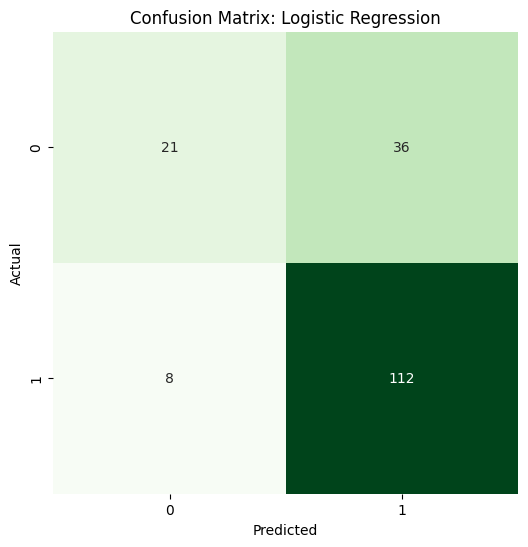

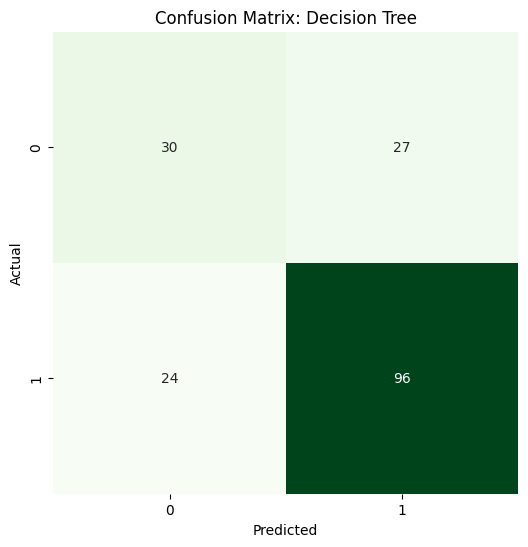

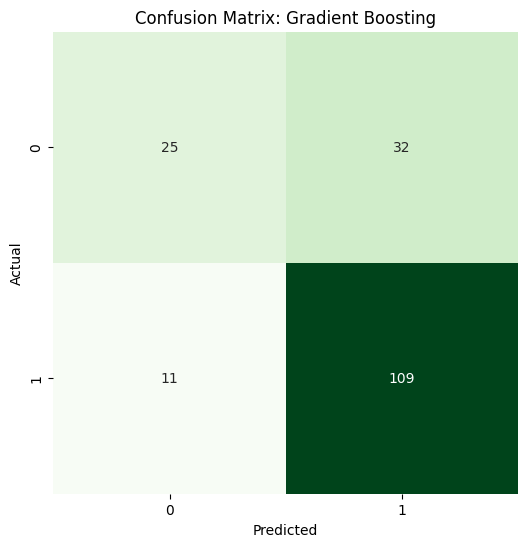

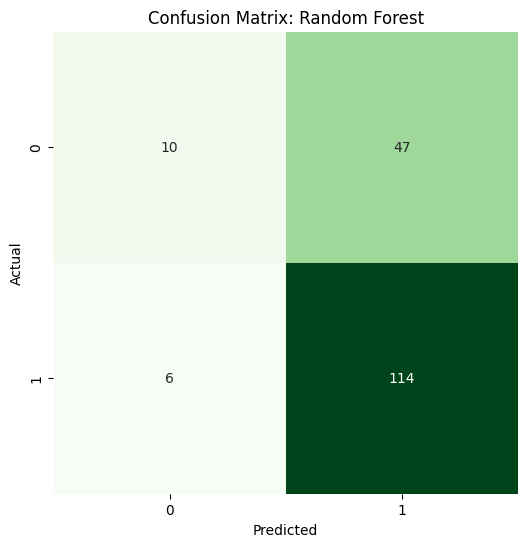

In [128]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(y_test, pred_lr, 'Confusion Matrix: Logistic Regression')
plot_confusion_matrix(y_test, pred_dt, 'Confusion Matrix: Decision Tree')
plot_confusion_matrix(y_test, pred_gbc, 'Confusion Matrix: Gradient Boosting')
plot_confusion_matrix(y_test, pred_rfc, 'Confusion Matrix: Random Forest')

Acuratetea si precizia modelelor

C:\Users\darius\AppData\Local\Temp\ipykernel_4552\3060658195.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


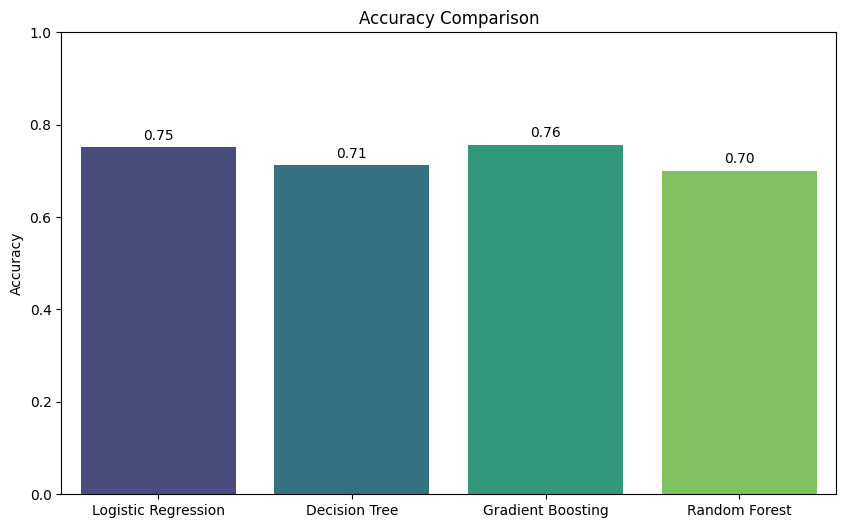

In [129]:
models = ['Logistic Regression', 'Decision Tree', 'Gradient Boosting', 'Random Forest']
predictions = [pred_lr, pred_dt, pred_gbc, pred_rfc]

accuracies = [accuracy_score(y_test, pred) for pred in predictions]
precisions = [precision_score(y_test, pred, pos_label=1) for pred in predictions] 
recalls = [recall_score(y_test, pred, pos_label=1) for pred in predictions]       
f1_scores = [f1_score(y_test, pred, pos_label=1) for pred in predictions]          

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.01, f'{accuracy:.2f}', ha='center', va='bottom')

plt.show()

<Figure size 1200x800 with 0 Axes>

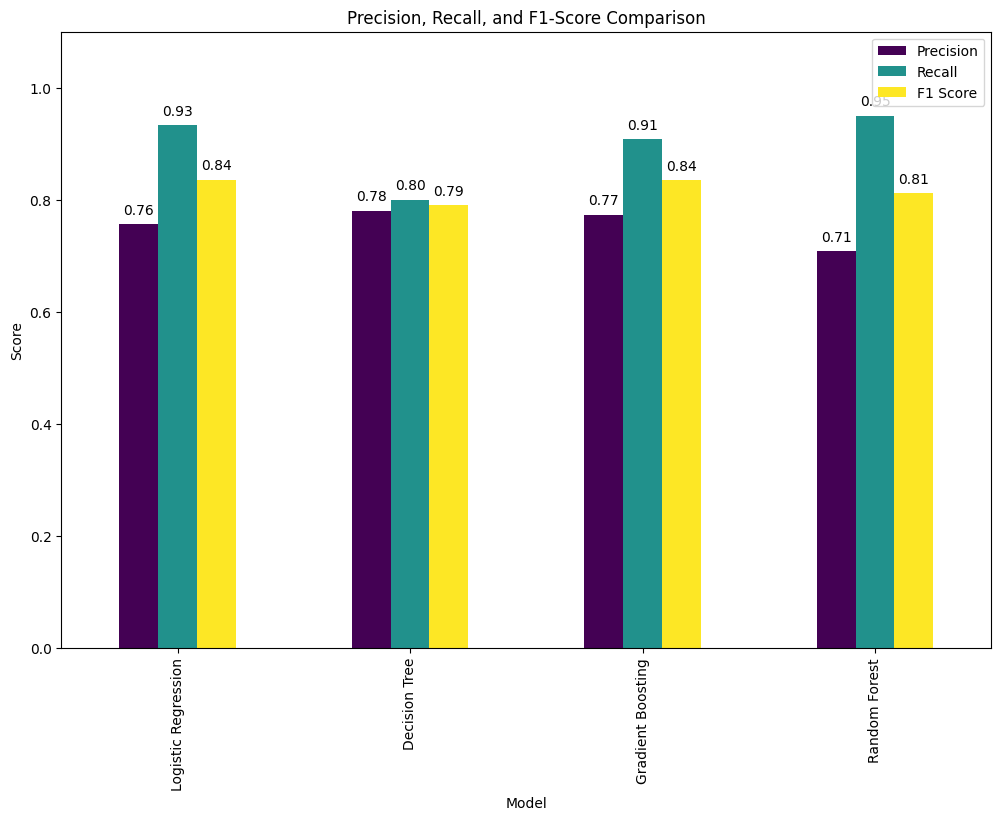

In [130]:
metrics = pd.DataFrame({
    'Model': models,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

plt.figure(figsize=(12, 8))
ax = metrics.set_index('Model').plot(kind='bar', figsize=(12, 8), colormap='viridis')
plt.title('Precision, Recall, and F1-Score Comparison')
plt.ylim(0, 1.1)
plt.ylabel('Score')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.show()
